# Klebs PhageHostLearn - baseline tests

### 1. Load libraries and set paths

In [1]:
import os
import umap
import math
import pickle
import phl_utils as phlu
import pandas as pd
import numpy as np
from Bio import SeqIO
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

path = '/Users/dimi/GoogleDrive/Phabric/2_DATA'
results_path = '/Users/dimi/GoogleDrive/Phabric/3_RESULTS'

Init Plugin
Init Graph Optimizer
Init Kernel


### 2. Train a new model on all Valencia data

In [2]:
# load original Valencia training data
valencia_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
valencia_ints = pd.read_csv(valencia_path+'/phage_host_interactionsValencia.csv', index_col=0)
valencia_ints
hosts = list(valencia_ints.index)
phages = list(valencia_ints.columns)
ints_df = {'host':[], 'phage':[], 'label':[]}
for i in range(valencia_ints.shape[0]):
    for j in range(valencia_ints.shape[1]):
        interaction = valencia_ints.iloc[i,j]
        if math.isnan(interaction) == False:
            ints_df['host'].append(hosts[i])
            ints_df['phage'].append(phages[j])
            ints_df['label'].append(int(interaction))

In [38]:
# add in vitro evaluation data
vitro_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS'
vitro_ints = pd.read_excel(vitro_path+'/experimental_validations.xlsx', sheet_name='Lab_results', index_col=0, header=0)
vitro_ints = vitro_ints.drop(['K-type \\ phages', 'Name'], axis=1)
vitrohosts = list(vitro_ints.index)
vitrophages = list(vitro_ints.columns)
vitro_ints.fillna(0, inplace=True)

for i in range(vitro_ints.shape[0]):
    for j in range(vitro_ints.shape[1]):
        interaction = vitro_ints.iloc[i,j]
        ints_df['host'].append(vitrohosts[i])
        ints_df['phage'].append(vitrophages[j])
        ints_df['label'].append(int(interaction))
        
pd.DataFrame(ints_df).to_csv(valencia_path+'/valencia_combined_interactions.csv', index=False)

In [39]:
# combine the two loci embedding files
loci1 = pd.read_csv(valencia_path+'/esm2_embeddings_lociValencia.csv')
loci2 = pd.read_csv('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/inference/esm2_embeddings_loci_test.csv')
valencia_loci = pd.concat([loci1, loci2], axis=0)
valencia_loci.to_csv(valencia_path+'/valencia_combined_locireps.csv', index=False)

filerbps = 'esm2_embeddings_rbpValencia2.csv'
phlu.combine_representations(filerbps, '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data', suffix='_rbps', mode='mean')

100%|██████████| 105/105 [00:00<00:00, 2580.47it/s]


In [47]:
# delete interactions related to the hosts or phages that are in interactions but missing from the embeddings
ints = pd.read_csv(valencia_path+'/valencia_combined_interactions.csv')
locireps = pd.read_csv(valencia_path+'/valencia_combined_locireps.csv')
phagereps = pd.read_csv(valencia_path+'/valencia_combined_phagereps.csv')
unknown_loci = [host for host in ints['host'] if host not in list(locireps['accession'])]
unknown_phage = [phage for phage in ints['phage'] if phage not in list(phagereps['accession'])]
ints = ints[~(ints['phage'].isin(unknown_phage) | ints['host'].isin(unknown_loci))]
ints.to_csv(valencia_path+'/valencia_combined_interactions.csv', index=False)

In [5]:
# combine all the loci sequences in one fasta file and do pairwise alignment to get a score matrix
from Bio import SeqIO
loci1 = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data/kaptive_results_all_loci.fasta'
loci2 = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/inference/kaptive_results_all_loci.fasta'

combinedfasta = open('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data/valencia_combined_lociseqs.fasta', 'w')
for rec in SeqIO.parse(loci1, 'fasta'):
    name = rec.id
    seq = str(rec.seq)
    combinedfasta.write('>'+name+'\n'+seq+'\n')
for rec in SeqIO.parse(loci2, 'fasta'):
    name = rec.id
    seq = str(rec.seq)
    combinedfasta.write('>'+name+'\n'+seq+'\n')
combinedfasta.close()

In [68]:
# construct groups at 95% for the bacterial loci
valencia_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
score_matrix = np.loadtxt(valencia_path+'/valencia_combined_loci_score_matrix.txt')
thres = 0.95
groups = [np.nan] * score_matrix.shape[0]
group_counter = 0
for i in range(score_matrix.shape[0]):
    cluster = np.where(score_matrix[i,:] > thres)[0]
    for index in cluster:
        if math.isnan(groups[index]):
            groups[index] = group_counter
        else:
            for newindex in cluster:
                groups[newindex] = groups[index]
    group_counter += 1

names = [rec.id for rec in SeqIO.parse(valencia_path+'/valencia_combined_lociseqs.fasta', 'fasta')]
groups_ml = [groups[names.index(host)] for host in ints['host']]

In [2]:
# train and eval new model on all Valencia data
valencia_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
filerbps = 'valencia_combined_phagereps.csv'
fileloci = 'valencia_combined_locireps.csv'
ints = pd.read_csv(valencia_path+'/valencia_combined_interactions.csv')

features, interactions = phlu.construct_inputframe(filerbps, fileloci, valencia_path, interactions=ints)
phlu.train_model(features, interactions, path, suffix='_valencia2', checkpoint=None)
#phlu.eval_model(features, labels, groups_ml, path, suffix='_valencia_combined')

100%|██████████| 10482/10482 [00:12<00:00, 840.31it/s]


Training from scratch...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=0.849 total time=   4.6s
[CV 2/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=0.875 total time=   4.7s
[CV 3/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=0.825 total time=   4.8s
[CV 4/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=0.877 total time=   4.8s
[CV 5/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=0.815 total time=   4.7s
[CV 1/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.867 total time=   8.6s
[CV 2/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.884 total time=   9.1s
[CV 3/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.826 tot

##### Compute metrics VALn -> VALn

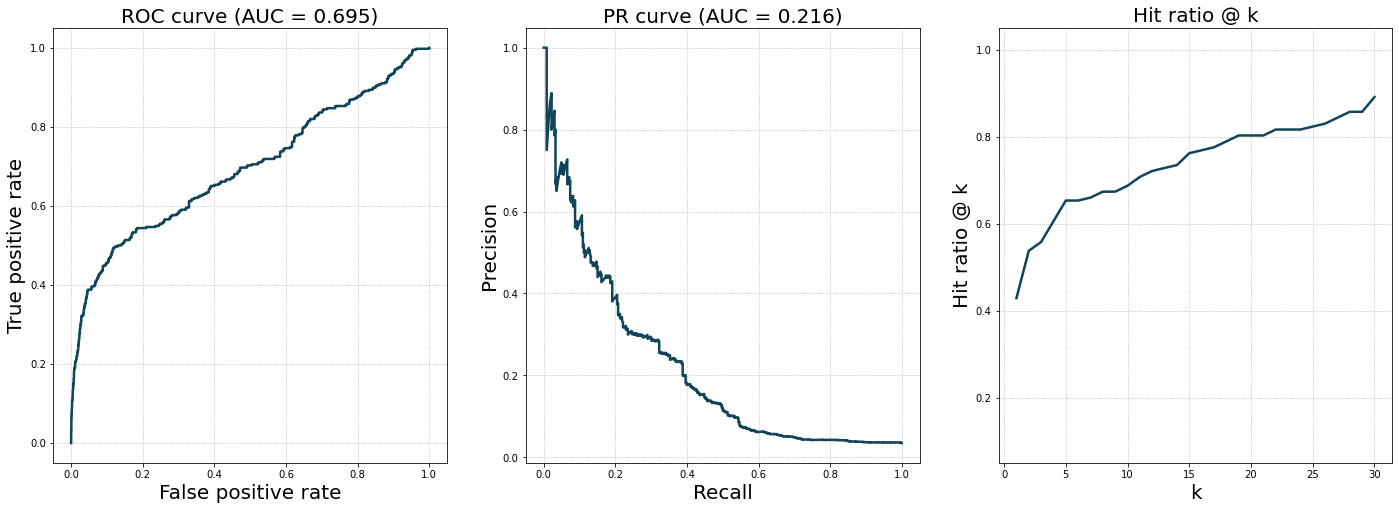

In [37]:
# compute performance of nested CV (on Dori)
res_path = '/Users/dimi/Desktop'
with open(res_path+'/cross_validated_results_valencia_combined_weight1logloss.pickle', 'rb') as f:
    results1 = pickle.load(f)
scores = results1['scores']
tindex = results1['test_index']
tic = list(np.concatenate(tindex).ravel())
lac = list(np.concatenate(scores).ravel())
sorted_scores = [x for _, x in sorted(zip(tic, lac))]

valencia_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
valints = pd.read_csv(valencia_path+'/valencia_combined_interactions.csv')
valints['prediction_score'] = sorted_scores
phlu.eval_report(valints, res_path, suffix='_VALn_combined_logloss_rocauc_weight1')

In [38]:
# hitratio @ 10
queries = []
for host in set(valints['host']):
    subpreds = valints[valints['host']==host]
    if sum(subpreds['label']) > 0:
        sublabels = subpreds['label']
        subscores = subpreds['prediction_score']
        sortpreds = [label for _, label in sorted(zip(subscores, sublabels), reverse=True)]
        queries.append(sortpreds)
phlu.hitratio(queries, 10)

0.6870748299319728

### 3. LYSO representations & inference

In [3]:
loci_file = 'loci_proteins.csv'
phlu.compute_representations(loci_file, path, suffix='_loci')

100%|██████████| 21356/21356 [8:15:45<00:00,  1.39s/it]   


In [ ]:
rbp_file = 'rbp_proteins.csv'
phlu.compute_representations(rbp_file, path, suffix='_rbps')

In [2]:
# combine to multi-representations
filerbps = 'representations_rbps.csv'
phlu.combine_representations(filerbps, path, suffix='_rbps', mode='mean')

fileloci = 'representations_loci.csv'
phlu.combine_representations(fileloci, path, suffix='_loci', mode='mean')

100%|██████████| 16558/16558 [1:32:05<00:00,  3.00it/s]  


In [27]:
# Get all the unknown interactions of phages and hosts that pass the quality filters
ints = pd.read_csv(path+'/interactions_rbplevel.csv')

def intsloop(ints, host, phage):
    new_ints = {'host': [], 'phage': [], 'label': []}
    if len(ints[(ints['host']==host) & (ints['phage']==phage)]) == 0:
        new_ints['host'].append(host)
        new_ints['phage'].append(phage)
        new_ints['label'].append(np.nan)
    return new_ints

new_ints = pd.DataFrame({'host': [], 'phage': [], 'label': []})
for host in tqdm(list(set(ints['host']))):
    results = Parallel(n_jobs=7)(delayed(intsloop)(ints, host, phage) for phage in list(set(ints['phage'])))
    these_ints = pd.concat([pd.DataFrame(d) for d in results], ignore_index=True)
    new_ints = pd.concat([new_ints, these_ints], axis=0)

print('loop is done!')
ints = pd.concat([ints, new_ints], axis=0)
ints.reset_index(drop=True, inplace=True)
print('True?', len(ints) == len(set(ints['host']))*len(set(ints['phage'])))
#ints.to_csv(path+'/interactions_rbplevel_all.csv', index=False) # save everything

  0%|          | 0/4441 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


loop is done!
True? True


In [2]:
# either subsample or just save everything
ints = pd.read_csv(path+'/interactions_rbplevel_all.csv')
known_ints = ints[ints['label'].notna()]
unknown_ints = ints[ints['label'].isna()]
sampled_unknown_ints = unknown_ints.sample(frac=0.00024, random_state=42)
sampled_ints = pd.concat([known_ints, sampled_unknown_ints], axis=0)

##### Make predictions VAL -> LYSO

In [3]:
# make predictions for the known ints
filerbps = 'representations_rbps.csv'
fileloci = 'representations_loci.csv'
model_file = 'phagehostlearn_valencia2.json'
features, interactions = phlu.construct_inputframe('multi_'+filerbps, 'multi_'+fileloci, path, interactions=sampled_ints)
predictions = phlu.predict_interactions(features, interactions, model_file, path, suffix='LYSO_valencia2', mode='scores')

100%|██████████| 26223/26223 [38:02<00:00, 11.49it/s]


Recall: 7.877116975187081e-05


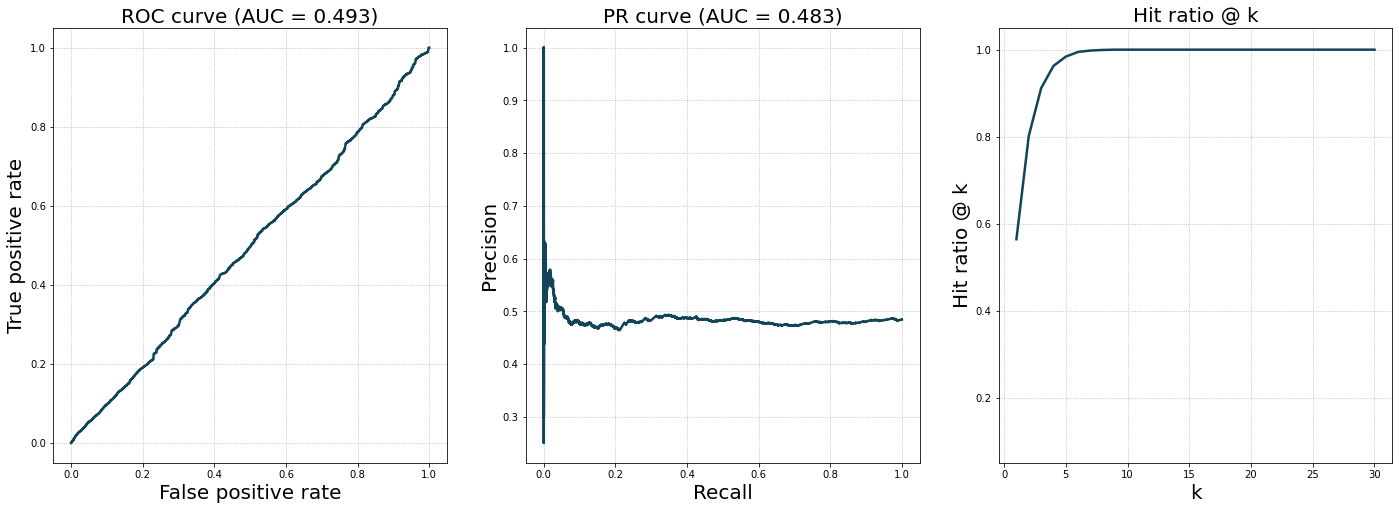

In [10]:
# compute results
preds_filtered = predictions[predictions['label'].notna()]
recall = recall_score(preds_filtered['label'], preds_filtered['prediction_score'] > 0.5)
print("Recall:", recall)

predictions['label'] = predictions['label'].fillna(0)
phlu.eval_report(predictions, results_path, suffix='_LYSO_valencia2')

##### Make predictions LYSO -> VAL

100%|██████████| 10482/10482 [00:10<00:00, 1004.01it/s]


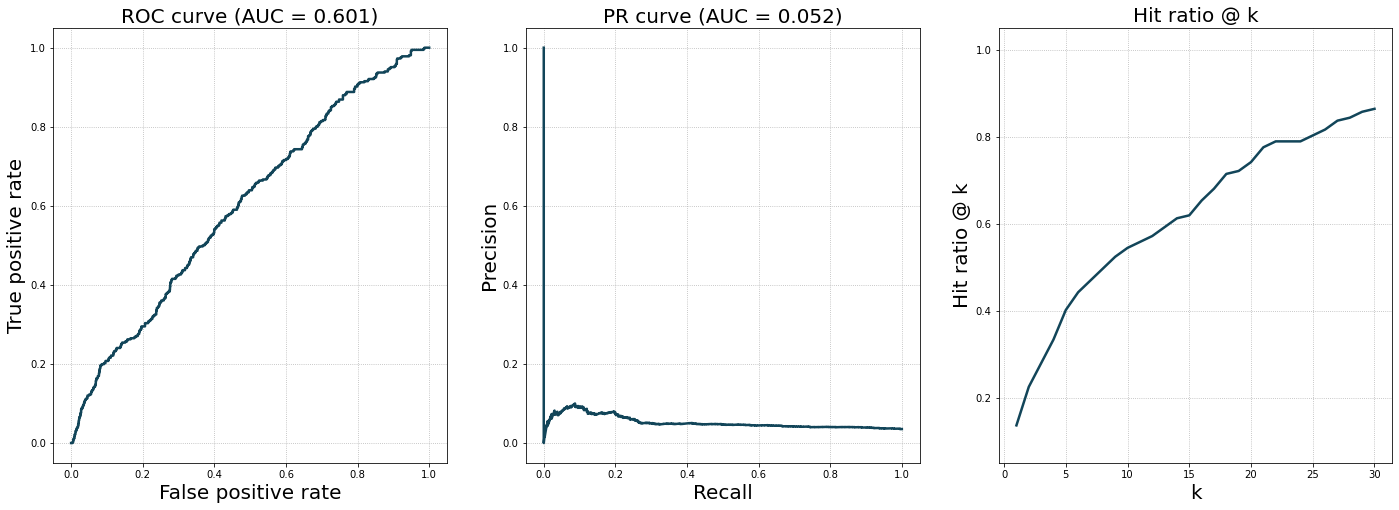

In [2]:
valpath = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
valints = pd.read_csv(valpath+'/valencia_combined_interactions.csv')
filerbps = 'valencia_combined_phagereps.csv'
fileloci = 'valencia_combined_locireps.csv'
model_file = 'phagehostlearn_lyso1.json'
features, interactions = phlu.construct_inputframe(filerbps, fileloci, valpath, interactions=valints)
predsvallyso = phlu.predict_interactions(features, interactions, model_file, path, suffix='VALn_lyso', mode='scores')
phlu.eval_report(predsvallyso, results_path, suffix='VALn_lyso')

##### Plot the prediction scores

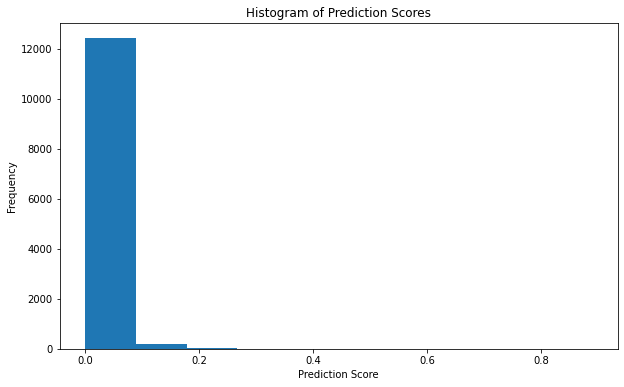

In [66]:
# plot the scores
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(predictions['prediction_score'])
ax.set_xlabel('Prediction Score')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Prediction Scores')
fig.savefig(path+'/prediction_scores_known_ints.png')

##### Look at the scores including RBPs that clustered together with Valencia RBPs

In [5]:
results_path = '/Users/dimi/GoogleDrive/Phabric/3_RESULTS'
clusters = open(results_path+'/phage_rbp_clusters.clstr')

phages_in_clusters = []
for line in clusters.readlines():
    if (line[0] != '>') and (line[0] != '0'): # in a cluster
        phages_in_clusters.append(line.split('>')[1].split('_gp')[0])
clusters.close()
len(set(phages_in_clusters))

2138

Text(0.5, 1.0, 'Histogram of Prediction Scores')

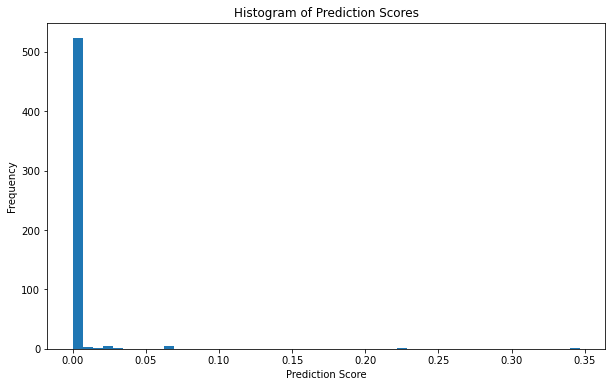

In [14]:
preds = pd.read_csv(path+'/predictions/predictions_known_ints.csv')
filtered_preds = preds[preds['phage'].isin(phages_in_clusters)]
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(filtered_preds['prediction_score'], bins=50)
ax.set_xlabel('Prediction Score')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Prediction Scores')

In [ ]:
# make predictions for the unknown ints
filerbps = 'representations_rbps.csv'
fileloci = 'representations_loci.csv'
model_file = 'phagehostlearn_esm2_xgb.json' # phagehostlearn_vbeta.json
batch_size = 20000
unknown_ints_sub = unknown_ints.iloc[:500000, :]

# iterate over ints in batches of 10,000 and construct the features and interactions
for i in tqdm(range(0, len(unknown_ints_sub), batch_size)):
    ints_batch = unknown_ints_sub[i:i+batch_size]
    features, interactions = phlu.construct_inputframe('multi_'+filerbps, 'multi_'+fileloci, path, interactions=ints_batch)
    interactions = phlu.predict_interactions(features, interactions, model_file, path+'/predictions', suffix='_'+str(i), mode='scores')

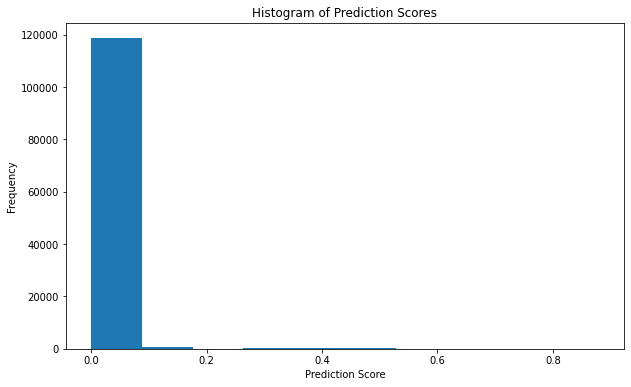

In [86]:
# combine the predictions
indices = ['0', '20000', '40000', '60000', '80000', '100000']
concat = []
for i in indices:
    predictions = pd.read_csv(path+'/predictions/predictions_'+str(i)+'.csv')
    concat.append(predictions)
preds = pd.concat(concat, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(preds['prediction_score'])
ax.set_xlabel('Prediction Score')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Prediction Scores')
fig.savefig(path+'/prediction_scores_unknown_ints.png')

##### Compute metrics LYSO -> LYSO

In [73]:
# load data
respath = '/Users/dimi/GoogleDrive/Phabric/3_RESULTS/baseline_eval'
predictions = pd.read_csv(respath+'/cvresults_LYSO.csv')

# delete the messed up indices from label0
predslabel0 = predictions[predictions['label'] == 0]
indices_notna = predslabel0[predslabel0['prediction_score'].notna()].index
predslabel0 = predslabel0.drop(indices_notna)

# get all the prediction scores, then merge
predslabel1 = predictions[predictions['label'] == 1]
scores1 = list(predslabel1['prediction_score'])
predsna = predictions[predictions['label'].isna()]
scores2 = list(predsna['prediction_score'])
preds_new = pd.concat([predslabel1, predslabel0], axis=0)
preds_new['prediction_score'] = scores1 + scores2

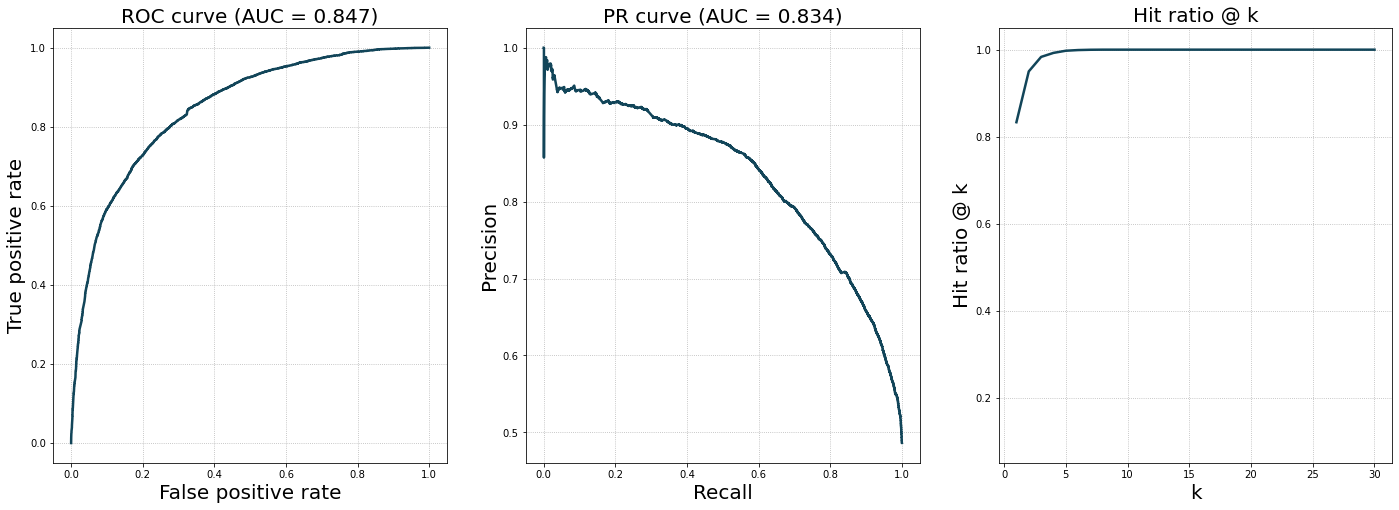

In [74]:
phlu.eval_report(preds_new, respath, suffix='_LYSO')


In [49]:
predslabel1 = predictions[predictions['label'] == 1]
# compute recall with sklearn
recall_score(predslabel1['label'], predslabel1['prediction_score'] > 0.5)

0.7410003938558487

### 4. KPC data representations & inference

##### Process the raw data

In [3]:
# process phage data
kpcpath ='/Users/dimi/GoogleDrive/Phabric/2_DATAKlebPhaCol'
phanotate_path = '/opt/homebrew/Caskroom/miniforge/base/envs/ML1/bin/phanotate.py'
model_path = '/Users/dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/RBPdetect_v3_ESMfineT33'
phlu.process_phages(kpcpath, phanotate_path, model_path, suffix='_KPC')
#phlu.phagerbpdetect(kpcpath, model_path, suffix='_KPC')

100%|██████████| 6374/6374 [1:26:55<00:00,  1.22it/s]  


In [2]:
# process bacterial data
kpcpath ='/Users/dimi/GoogleDrive/Phabric/2_DATAKlebPhaCol'
kaptive_path = '/Users/dimi/Documents/GitHub/PhageHostLearn/code/kaptive.py'
db_path = '/Users/dimi/GoogleDrive/Phabric/2_DATA/Klebsiella_k_locus_primary_reference.gbk'
phlu.process_bacteria(kpcpath, kaptive_path, db_path, suffix='')

Running Kaptive


  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [2:22:27<00:00, 140.12s/it]    


In [19]:
# process interactions
kpcints = pd.read_excel(kpcpath+'/interactions.xlsx', sheet_name='Hoja1', index_col=1, header=2)
kpcints = kpcints.iloc[3:,1:]
kpcphages = list(kpcints.index)
kpcphosts = list(kpcints.columns)
ints_df = {'host':[], 'phage':[], 'label':[]}
phagefiles = [file.split('.fasta')[0] for file in os.listdir(kpcpath+'/phage_genomes') if (file.endswith('.fasta')) or (file.endswith('.fna'))]
hostfiles = [file.split('.fasta')[0] for file in os.listdir(kpcpath+'/bacterial_genomes') if (file.endswith('.fasta')) or (file.endswith('.fna'))]

for i in range(kpcints.shape[0]): # phages in this case
    for j in range(kpcints.shape[1]): # hosts
        interaction = kpcints.iloc[i,j]
        if (interaction == 0) or (interaction == 1):
            if (kpcphosts[j] in hostfiles) and (kpcphages[i] in phagefiles):
                ints_df['host'].append(kpcphosts[j])
                ints_df['phage'].append(kpcphages[i])
                ints_df['label'].append(int(interaction))

pd.DataFrame(ints_df).to_csv(kpcpath+'/kpc_interactions.csv', index=False)

##### Compute features

In [ ]:
kpcpath ='/Users/dimi/GoogleDrive/Phabric/2_DATAKlebPhaCol'
loci_file = 'locis_KPC.csv'
phlu.compute_representations(loci_file, kpcpath, suffix='_loci_KPC')

rbp_file = 'rbps_KPC.csv'
phlu.compute_representations(rbp_file, kpcpath, suffix='_rbps_KPC')

In [3]:
# combine to multi-representations
kpcpath = '/Users/dimi/GoogleDrive/Phabric/2_DATAKlebPhaCol'
filerbps = 'representations_rbps_KPC.csv'
phlu.combine_representations(filerbps, kpcpath, suffix='_rbps_KPC', mode='mean')

fileloci = 'representations_loci_KPC.csv'
phlu.combine_representations(fileloci, kpcpath, suffix='_loci_KPC', mode='mean')

100%|██████████| 61/61 [00:00<00:00, 1297.57it/s]


##### Make predictions VAL -> KPC

In [13]:
# make predictions for the known ints
kpcpath = '/Users/dimi/GoogleDrive/Phabric/2_DATAKlebPhaCol'
ints = pd.read_csv(kpcpath+'/interactions_KPC.csv')
filerbps = 'representations_rbps_KPC.csv'
fileloci = 'representations_loci_KPC.csv'
model_file = 'phagehostlearn_valencia2.json'
features, interactions = phlu.construct_inputframe('multi_'+filerbps, 'multi_'+fileloci, kpcpath, interactions=ints)
preds = phlu.predict_interactions(features, interactions, model_file, path, suffix='_KPC_valencia2', mode='scores')
# see: https://stackoverflow.com/questions/43404877/pandas-how-to-concat-two-dataframes-without-losing-the-column-headers

100%|██████████| 1731/1731 [00:00<00:00, 2059.78it/s]


In [15]:
from sklearn.metrics import recall_score
recall_score(preds['label'], preds['prediction_score'] > 0.5)

0.08614232209737828

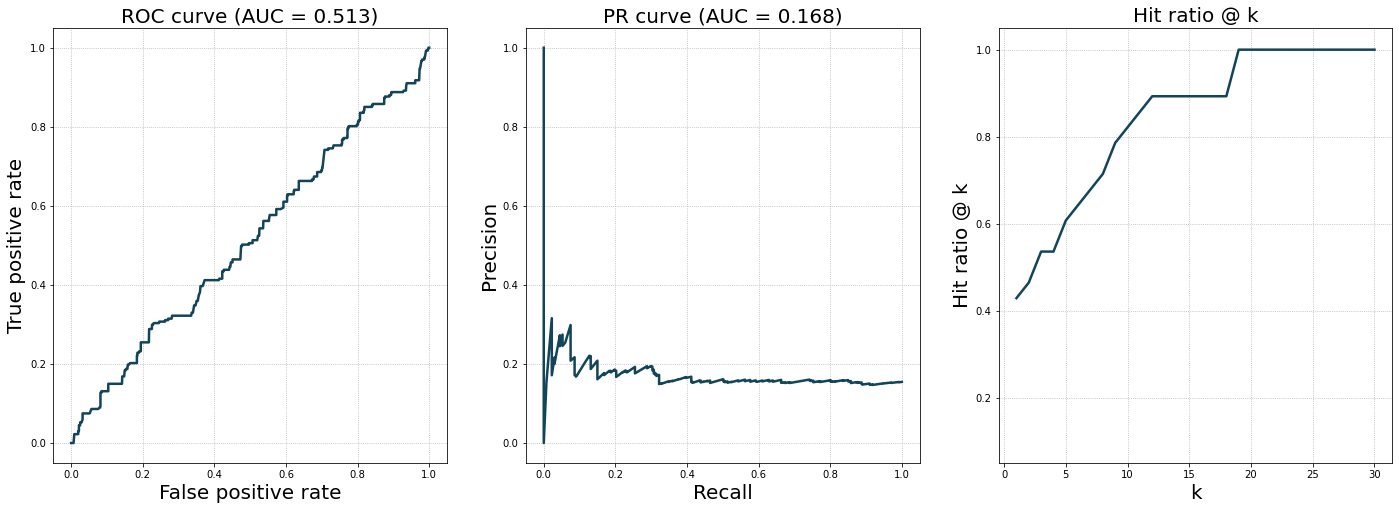

In [16]:
phlu.eval_report(preds, results_path, suffix='_KPC_valencia2')

##### Compute metrics KPC -> KPC

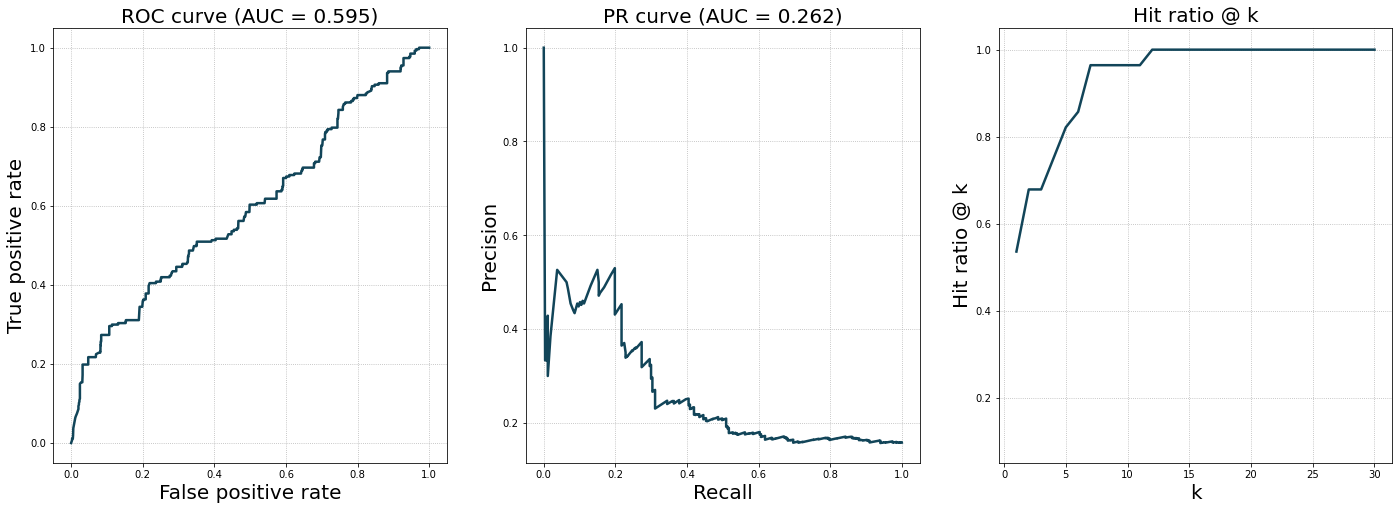

In [3]:
respath = '/Users/dimi/GoogleDrive/Phabric/3_RESULTS/baseline_eval'
predictions = pd.read_csv(respath+'/cvresults_KPC.csv')
phlu.eval_report(predictions, respath, suffix='_KPC')

In [4]:
queries = []
for host in set(predictions['host']):
    subpreds = predictions[predictions['host']==host]
    if sum(subpreds['label']) > 0:
        sublabels = subpreds['label']
        subscores = subpreds['prediction_score']
        sortpreds = [label for _, label in sorted(zip(subscores, sublabels), reverse=True)]
        queries.append(sortpreds)
phlu.hitratio(queries, 10)

0.9642857142857143

##### Train a model from scratch on KPC data

In [2]:
# train and eval new model on all Valencia data
kpcpath = '/Users/dimi/GoogleDrive/Phabric/2_DATAKlebPhaCol'
kpcints = pd.read_csv(kpcpath+'/interactions_KPC.csv')
filerbps = 'multi_representations_rbps_KPC.csv'
fileloci = 'multi_representations_loci_KPC.csv'

features, interactions = phlu.construct_inputframe(filerbps, fileloci, kpcpath, interactions=kpcints)
phlu.train_model(features, interactions, kpcpath, suffix='_kpc1', checkpoint=None)

100%|██████████| 1731/1731 [00:00<00:00, 2504.23it/s]


Training from scratch...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.934 total time=   1.3s
[CV 2/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.934 total time=   1.3s
[CV 3/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.899 total time=   1.4s
[CV 4/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.921 total time=   1.3s
[CV 5/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.924 total time=   1.3s
[CV 1/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300;, score=0.942 total time=   2.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300;, score=0.943 total time=   2.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300;, score=0.903 tot

##### Make predictions KPC -> VAL

100%|██████████| 10482/10482 [00:09<00:00, 1085.51it/s]


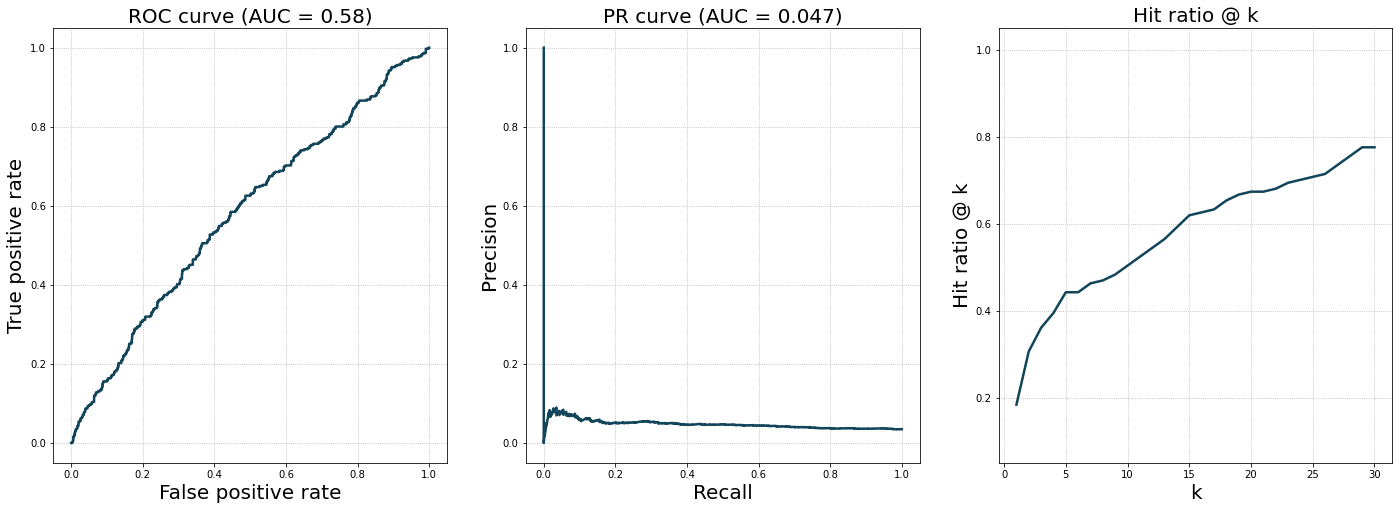

In [8]:
# test on VALn data
valpath = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
valints = pd.read_csv(valpath+'/valencia_combined_interactions.csv')
filerbps = 'valencia_combined_phagereps.csv'
fileloci = 'valencia_combined_locireps.csv'
model_file = 'phagehostlearn_kpc1.json'
features, interactions = phlu.construct_inputframe(filerbps, fileloci, valpath, interactions=valints)
predsvalkpc = phlu.predict_interactions(features, interactions, model_file, path, suffix='VALn_kpc1', mode='scores')
phlu.eval_report(predsvalkpc, respath, suffix='VALn_kpc1')

### 4. UMAP of phage reps

In [4]:
# combine the individual RBP reps of LYT data
lyt_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
filerbps = 'esm2_embeddings_rbpValencia.csv'
phlu.combine_representations(filerbps, '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data', suffix='_rbps', mode='mean')

100%|██████████| 105/105 [00:00<00:00, 2291.67it/s]


In [42]:
lyt_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
phagereps_lyso = pd.read_csv(path+'/multi_representations_rbps.csv')
phagereps_lyt = pd.read_csv(lyt_path+'/multi_representations_rbps.csv')

# filter the phagereps_lyso based on the phages in known_ints
ints = pd.read_csv(path+'/interactions_rbplevel_all.csv')
known_ints = ints[ints['label'].notna()]
phagereps_lyso = phagereps_lyso[phagereps_lyso['accession'].isin(list(set(known_ints['phage'])))]

features = pd.concat([phagereps_lyso.iloc[:, 1:], phagereps_lyt.iloc[:, 1:]], axis=0)
names = list(phagereps_lyso['accession']) + list(phagereps_lyt['accession'])
labels = ['Lyso']*len(phagereps_lyso) + ['Lyt']*len(phagereps_lyt)
print('True?', len(features) == len(labels))

True? True


In [43]:
# Perform UMAP with 3 components
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(features)

embedding_df = pd.DataFrame(embedding, columns=['Component 1', 'Component 2', 'Component 3'])
embedding_df['label'] = labels
embedding_df['accession'] = names

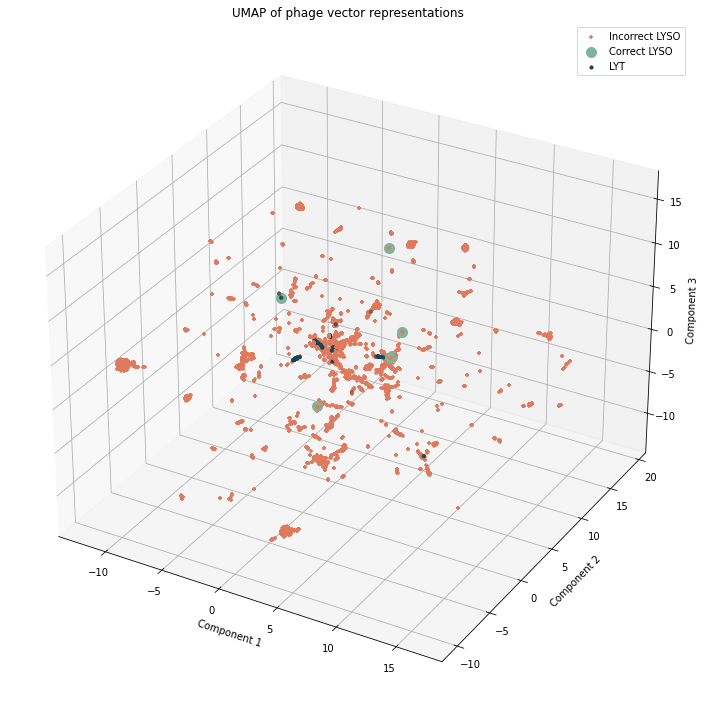

In [54]:
# plot UMAP and color by correct preds
preds = pd.read_csv(path+'/predictions/predictions_known_ints.csv')
correct = list(preds['phage'][preds['prediction_score'] > 0.5])

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, projection='3d')

embedding_df_lyso = embedding_df[embedding_df['label'] == 'Lyso']
for i, label in enumerate(embedding_df_lyso['label']):
    if list(embedding_df_lyso['accession'])[i] in correct:
        ax.scatter(list(embedding_df_lyso['Component 1'])[i], list(embedding_df_lyso['Component 2'])[i], list(embedding_df_lyso['Component 3'])[i], c='#81B29A', s=100, label='Correct LYSO')
    else:
        ax.scatter(list(embedding_df_lyso['Component 1'])[i], list(embedding_df_lyso['Component 2'])[i], list(embedding_df_lyso['Component 3'])[i], c='#E07A5F', marker='+', s=10, label='Incorrect LYSO')

embedding_df_lyt = embedding_df[embedding_df['label'] == 'Lyt']
ax.scatter(embedding_df_lyt['Component 1'], embedding_df_lyt['Component 2'], embedding_df_lyt['Component 3'], c='#124559', s=10, label='LYT')

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
min_x = embedding_df['Component 1'].min(); max_x = embedding_df['Component 1'].max()
min_y = embedding_df['Component 2'].min(); max_y = embedding_df['Component 2'].max()
min_z = embedding_df['Component 3'].min(); max_z = embedding_df['Component 3'].max()
ax.set_xlim(min_x-0.2, max_x+0.2)
ax.set_ylim(min_y-0.2, max_y+0.2)
ax.set_zlim(min_z-0.2, max_z+0.2)
ax.set_title('UMAP of phage vector representations')
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))

fig.tight_layout()
fig.savefig(results_path+'/umap_phage_reps.png', dpi=600)

### 5. UMAP of host reps

In [18]:
# get the data and combine the representations
lyt_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
lytloci = pd.read_csv(lyt_path+'/esm2_embeddings_lociValencia.csv')
lysoloci = pd.read_csv(path+'/multi_representations_loci.csv')

# filter the phagereps_lyso based on the phages in known_ints
ints = pd.read_csv(path+'/interactions_rbplevel_all.csv')
known_ints = ints[ints['label'].notna()]
lysoloci = lysoloci[lysoloci['accession'].isin(list(set(known_ints['host'])))]

features_host = pd.concat([lysoloci.iloc[:, 1:], lytloci.iloc[:, 1:]], axis=0)
names_host = list(lysoloci['accession']) + list(lytloci['accession'])
labels_host = ['Lyso']*len(lysoloci) + ['Lyt']*len(lytloci)

# collect KL-types
loci_summary = pd.read_csv(path+'/loci_summary.csv')
kls = []
for acc in lysoloci['accession']:
    kls.append(list(loci_summary['KL-type'][loci_summary['accession'] == acc])[0])
lytkl = pd.read_csv(lyt_path+'/serotypesValencia.csv')
kls = kls + list(lytkl['sero'])
klpairs = [(kl, kls.count(kl)) for kl in kls]
sorted_klpairs = sorted(set(klpairs), key = lambda x: x[1], reverse=True)
top20kl = [kl for (kl, count) in sorted_klpairs[:20]]


In [32]:
# Perform UMAP with 3 components
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(features_host)

embedding_df = pd.DataFrame(embedding, columns=['Component 1', 'Component 2', 'Component 3'])
embedding_df['label'] = labels_host
embedding_df['accession'] = names_host
embedding_df['KL-type'] = kls

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

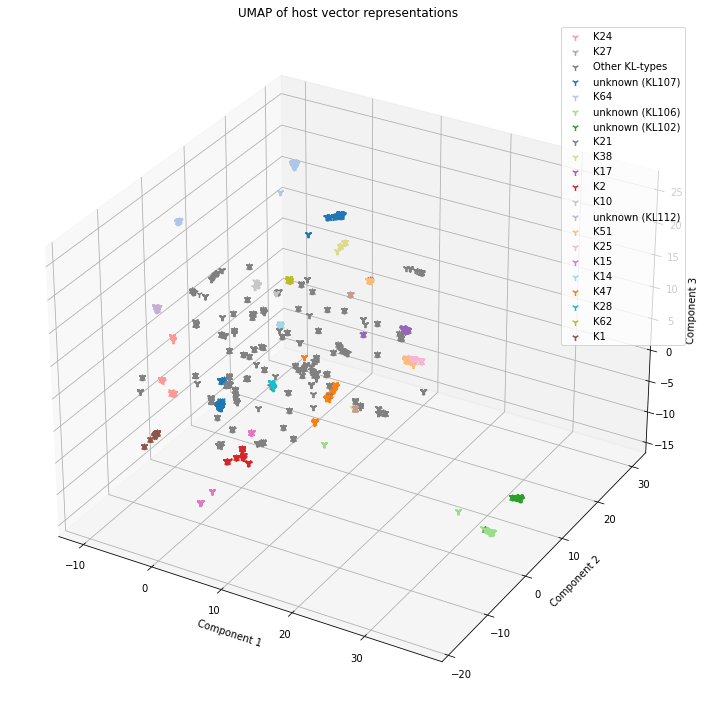

In [39]:
# plot the UMAP
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.cm.get_cmap('tab20', 20)
top20kl_colors = {kl: cmap(i) for i, kl in enumerate(top20kl)}
markers = {'Lyso': '1', 'Lyt': '^'}
sizes = {'Lyso': 50, 'Lyt': 30}

for i, kl in enumerate(embedding_df['KL-type']):
    if kl in top20kl:
        ax.scatter(list(embedding_df['Component 1'])[i], list(embedding_df['Component 2'])[i], list(embedding_df['Component 3'])[i], c=top20kl_colors[kl], 
                   s=sizes[embedding_df['label'][i]], label=kl, marker=markers[embedding_df['label'][i]])
    else:
        ax.scatter(list(embedding_df['Component 1'])[i], list(embedding_df['Component 2'])[i], list(embedding_df['Component 3'])[i], c='grey', 
                   s=sizes[embedding_df['label'][i]], label='Other KL-types', marker=markers[embedding_df['label'][i]])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
min_x = embedding_df['Component 1'].min(); max_x = embedding_df['Component 1'].max()
min_y = embedding_df['Component 2'].min(); max_y = embedding_df['Component 2'].max()
min_z = embedding_df['Component 3'].min(); max_z = embedding_df['Component 3'].max()
ax.set_xlim(min_x-0.2, max_x+0.2)
ax.set_ylim(min_y-0.2, max_y+0.2)
ax.set_zlim(min_z-0.2, max_z+0.2)
ax.set_title('UMAP of host vector representations')
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))

fig.tight_layout()
fig.savefig(results_path+'/umap_host_reps.png', dpi=600)

### 6. UMAP of all combined (known) reps

In [2]:
# get the lytic features
lyt_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
lytfeats = np.loadtxt(lyt_path+'/lyt_features.txt', delimiter=',')

# get the lysogenic features
filerbps = 'representations_rbps.csv'
fileloci = 'representations_loci.csv'
ints = pd.read_csv(path+'/interactions_rbplevel_all.csv')
known_ints = ints[ints['label'].notna()]
lysofeats, interactions = phlu.construct_inputframe('multi_'+filerbps, 'multi_'+fileloci, path, interactions=known_ints)

100%|██████████| 12695/12695 [16:30<00:00, 12.82it/s]


In [3]:
# Perform UMAP with 3 components
reducer = umap.UMAP(n_components=3)
allfeats = np.concatenate((lysofeats, lytfeats), axis=0)
alllabels = ['Lyso']*len(lysofeats) + ['Lyt']*len(lytfeats)
embedding = reducer.fit_transform(allfeats)

embedding_df = pd.DataFrame(embedding, columns=['Component 1', 'Component 2', 'Component 3'])
embedding_df['label'] = alllabels

/opt/homebrew/Caskroom/miniforge/base/envs/ML1/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


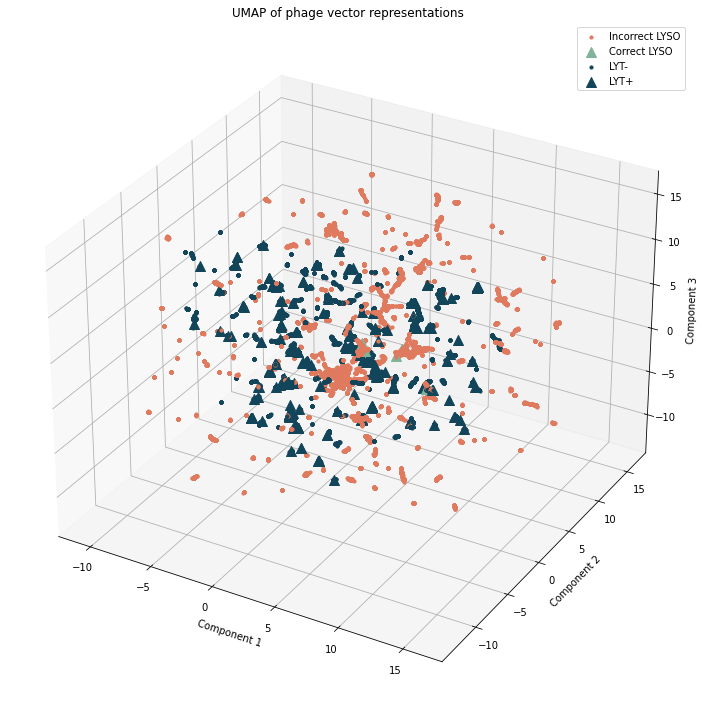

In [4]:
# plot UMAP and color by correct preds
preds = pd.read_csv(path+'/predictions/predictions_known_ints.csv')
scores = list(preds['prediction_score'])
labelslyt = pd.read_csv(lyt_path+'/labels.csv')
labelslyt = list(labelslyt['label'])

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, projection='3d')

embedding_df_lyso = embedding_df[embedding_df['label'] == 'Lyso']
for i, label in enumerate(embedding_df_lyso['label']):
    if scores[i] > 0.5: # correct preds
        ax.scatter(list(embedding_df_lyso['Component 1'])[i], list(embedding_df_lyso['Component 2'])[i], list(embedding_df_lyso['Component 3'])[i], c='#81B29A', marker='^', s=100, label='Correct LYSO')
    else:
        ax.scatter(list(embedding_df_lyso['Component 1'])[i], list(embedding_df_lyso['Component 2'])[i], list(embedding_df_lyso['Component 3'])[i], c='#E07A5F', s=10, label='Incorrect LYSO')

embedding_df_lyt = embedding_df[embedding_df['label'] == 'Lyt']
tplus = 0
tmin = 0
for i, label in enumerate(embedding_df_lyt['label']):
    if labelslyt[i] == 1:
        ax.scatter(list(embedding_df_lyt['Component 1'])[i], list(embedding_df_lyt['Component 2'])[i], list(embedding_df_lyt['Component 3'])[i], c='#124559', marker='^', s=100, label='LYT+')
        tplus += 1
    else:
        ax.scatter(list(embedding_df_lyt['Component 1'])[i], list(embedding_df_lyt['Component 2'])[i], list(embedding_df_lyt['Component 3'])[i], c='#124559', facecolors='none', s=10, label='LYT-')
        tmin += 1

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
min_x = embedding_df['Component 1'].min(); max_x = embedding_df['Component 1'].max()
min_y = embedding_df['Component 2'].min(); max_y = embedding_df['Component 2'].max()
min_z = embedding_df['Component 3'].min(); max_z = embedding_df['Component 3'].max()
ax.set_xlim(min_x-0.2, max_x+0.2)
ax.set_ylim(min_y-0.2, max_y+0.2)
ax.set_zlim(min_z-0.2, max_z+0.2)
ax.set_title('UMAP of phage vector representations')
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))

fig.tight_layout()
fig.savefig(results_path+'/umap_featuresspace.png', dpi=600)

In [5]:
print(tplus, tmin)

333 9673


In [ ]:
# make predictions
#model_file = 'phagehostlearn_esm2_xgb.json'
#predictions = phlu.predict_interactions(features, interactions, model_file, path, suffix='', mode='scores')

In [ ]:
# add the labels that are known to the preds, rest is NaN
# for those that are known, compute the recall
# for all (known and unknown), plot the score distribution (histogram)